In [152]:
import torch, random
from copy import deepcopy
import numpy as np
from torch import nn, optim
from torch.nn import ModuleList, functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import deque

In [153]:
class Board:
    dx = [1, 0, 1, 1]
    dy = [0, 1, 1, -1]
    def __init__(self) -> None:
        self.board = [[0]*6 for _ in range(7)]
        self.turn = 1
        self.played = set()
        self.win = None
        self.columns = [0] * 7

    def __str__(self):
        ret = ""
        for i in reversed(list(zip(*self.board))):
            ret += "|"
            for j in i:
                ret += str(j).rjust(3)
            ret += " |\n"
        return ret
    def play(self, col):
        if self.columns[col] >= 6: return
        self.board[col][self.columns[col]] = self.turn
        self.played.add((col, self.columns[col]))
        self.columns[col] += 1
        self.turn *= -1
        self.win = self.check_win()
        return self.win
    def reward(self, col=-1, *, inverted=1):
        total = 0
        if col != -1:
            self.board[col][self.columns[col]] = self.turn
        for posx in range(7):
            for posy in range(6):
                color = self.board[posx][posy]
                if color == 0:
                    continue
                for k in range(4):
                    count = 1
                    multiplier = 2
                    for sign in [-1, 1]:
                        for l in range(1, 4): 
                            r = posx + self.dx[k]*l*sign
                            c = posy + self.dy[k]*l*sign
                            if not (0 <= r < 7 and 0 <= c < 6):
                                multiplier -= 1
                                break
                            if self.board[r][c] !=color:
                                if self.board[r][c] == -color: multiplier -= 1
                                break
                            # print(r, c)
                            count += 1
                            if count >= 4:
                                if col != -1: self.board[col][self.columns[col]] = 0
                                return 20
                    # print('mc',multiplier, count)
                    total += (multiplier * count) **3/30 * (1 if color == self.turn*inverted else -1)
        if col != -1:
            self.board[col][self.columns[col]] = 0
        
        return total
    def reward_of(self, col):
        posx, posy = pos = (col, self.columns[col])
        color = self.turn
        total = 0
        for k in range(4):
            count = 1
            multiplier = 2
            for sign in [-1, 1]:
                for l in range(1, 4): 
                    r = posx + self.dx[k]*l*sign
                    c = posy + self.dy[k]*l*sign
                    if not (0 <= r < 7 and 0 <= c < 6):
                        multiplier -= 1
                        break
                    if self.board[r][c] !=color:
                        if self.board[r][c] == -color: multiplier -= 1
                        break
                    # print(r, c)
                    count += 1
                    if count >= 4:
                        return 20
            # print('mc',multiplier, count)
            total += (multiplier * count) **3/30
        return total
    def inverted(self):
        return [[j*(-1) for j in i] for i in self.board]
    def check_win(self):
        for i, j in self.played:
            color = self.board[i][j]
            for k in range(3):
                for l in range(1, 4):
                    r = i + self.dx[k]*l 
                    c = j + self.dy[k]*l 
                    if not (0 <= r < 7 and 0 <= c < 6): break
                    if self.board[r][c] != color: break
                else:
                    return color
        if sum(self.columns) == 42: return 0
        return None
    def to_tensor(self, turn=None, *, make_batch=False):
        if make_batch:
            return torch.tensor([[self.board if turn == None and self.turn == 1 else self.inverted()]], dtype=torch.float32)

        return torch.tensor([self.board if turn == None and self.turn == 1 else self.inverted()], dtype=torch.float32)
    def legal(self):
        return {i for i in range(7) if self.columns[i] < 6}
    def filter_illegal_max(self, vals):
        m = None
        for i in self.legal():
            if m is None or vals[0][m]< vals[0][i]:
                m = i
        return m
    
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        # RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x4 and 24x120)
        # self.conv1 = nn.Conv2d(1, 6, 3)
        self.fc0 = nn.Linear(42, 80)
        self.fc1 = nn.Linear(80, 60)
        self.fc2 = nn.Linear(60, 20)
        self.fc3 = nn.Linear(20, 7)
        for i in [self.fc0, self.fc1, self.fc2, self.fc3]:
            nn.init.kaiming_normal_(i.weight)
        self.loss = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.00025)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        # x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
WIN = 10
BATCH_SIZE = 10
GAMMA = 0.9
class Agent:
    def __init__(self, board: Board) -> None:
        self.model = NN()
        self.t_model = NN()
        self.update_t = 0
        self.exp = deque()
        self.interval = 50
        self.losses_x = []
        self.losses_y = []
        self.x = 0
        self.epsilon = 0
        self.board = board
        self.loss_f = nn.MSELoss()
        self.copy()
    def copy(self):
        self.t_model.load_state_dict(self.model.state_dict())
    
    def legal_mask(self, states):
        ret = []
        for board in states:
            row = [1 if 0 in col else 0 for col in board]
            ret.append(row)
        return torch.tensor(ret, dtype=torch.float32)
                
        
    def step(self):
        s = self.board.to_tensor()
        if random.random() < self.epsilon:
            a = self.board.filter_illegal_max(self.model(self.board.to_tensor(make_batch=True)))
        else:
            a = random.choice(list(self.board.legal()))
        r = self.board.reward()
        self.board.play(a)
        if self.board.win is None:
            new_board = deepcopy(self.board)
            oppo_a = new_board.filter_illegal_max(self.model(new_board.to_tensor(make_batch=True)))
            # print(oppo_a)
            # r -= new_board.reward_of(oppo_a) * 1.1
            new_board.play(oppo_a)
            r = new_board.reward() - r
            new_s = new_board.to_tensor()
            # print(a, oppo_a)
        else:
            new_s = self.board.to_tensor(-1)
            r = 0 if board.win == 0 else 10000
        # print("new", r)
        # print()
        
        # print(r)
        # print()
        # new_s = self.board.to_tensor(-1)
        self.exp.append((s, a, r, new_s))
        if len(self.exp) < BATCH_SIZE:
            return
        self.model.optimizer.zero_grad()
        batch = random.sample(self.exp, BATCH_SIZE)
        states, actions, rewards, new_states = zip(*batch)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        # print(actions)
        for _ in range(1):
            q = self.model(torch.stack(states)).gather(1, torch.tensor(actions, dtype=torch.int64).unsqueeze(-1)).flatten(0)
            target_q = (self.t_model(torch.stack(new_states))*self.legal_mask(new_states)).max(1)[0]*GAMMA + rewards
            # for i in states: print(i)
            # print(q)
            # print(rewards)
            # print(target_q)
            loss = self.loss_f(q, target_q)
            
            loss.backward()
            self.model.optimizer.step()
        self.update_t += 1
        # if self.update_t % 5 == 0:
        #         self.losses_y.append(int(loss))
        #         self.losses_x.append(self.x)
        #         self.x+=1
        if self.update_t >= self.interval:
            self.update_t = 0
            self.copy()
        if self.board.win is not None:
            # print(self.board)
            self.epsilon += (1-self.epsilon)* 0.05
            self.board = Board()

100%|██████████| 5000/5000 [00:11<00:00, 453.70it/s]


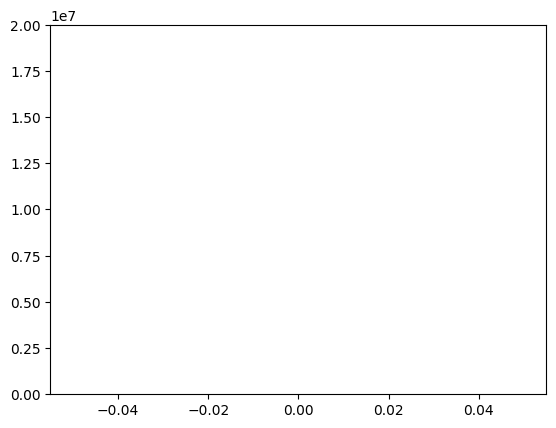

In [154]:
board = Board()
p1 = Agent(board)
for i in tqdm(range(5000)):
    p1.step()
plt.scatter(p1.losses_x, p1.losses_y)
plt.ylim([0, 2e7])
plt.show()
# add legal mask to the target

In [155]:
board = Board()
p1.board = board
while board.win is None:
    # if board.turn == 1:
    #     a = int(input("Move: "))
    #     board.play(a)
    # else:
    values = p1.model(board.to_tensor(make_batch=True))
    # print(f"reward: {[board.reward_of(i) if i in board.legal() else 0 for i in range(7)]}")
    a = board.filter_illegal_max(values)
    r = board.reward()
    print(f"AI{1 if board.turn == 1 else 2} played {a}: {values}")
    # print(f"reward: {[board.reward_of(i) if i in board.legal() else 0 for i in range(7)]}")
    print(f"reward: {[board.reward(i) - r if i in board.legal() else 0 for i in range(7)]}")
    board.play(a)
    print(board)
print(f"AI{1 if board.win == 1 else 2} Won")

AI1 played 4: tensor([[88800.9297, 81848.9766, 77522.2344, 46648.0742, 93856.6328, 83832.0078,
         85191.0000]], grad_fn=<AddmmBackward0>)
reward: [0.1, 0.36666666666666664, 0.36666666666666664, 0.36666666666666664, 0.36666666666666664, 0.36666666666666664, 0.1]
|  0  0  0  0  0  0  0 |
|  0  0  0  0  0  0  0 |
|  0  0  0  0  0  0  0 |
|  0  0  0  0  0  0  0 |
|  0  0  0  0  0  0  0 |
|  0  0  0  0  1  0  0 |

AI2 played 4: tensor([[71641.7266, 66033.6797, 62541.5508, 37632.6758, 75721.2891, 67629.1328,
         68726.4297]], grad_fn=<AddmmBackward0>)
reward: [0.09999999999999998, 0.36666666666666664, 0.36666666666666664, 0.36666666666666664, 0.8666666666666667, 0.36666666666666664, 0.09999999999999998]
|  0  0  0  0  0  0  0 |
|  0  0  0  0  0  0  0 |
|  0  0  0  0  0  0  0 |
|  0  0  0  0  0  0  0 |
|  0  0  0  0 -1  0  0 |
|  0  0  0  0  1  0  0 |

AI1 played 4: tensor([[132077.2344, 121737.5547, 115304.2344,  69385.4141, 139595.6562,
         124695.4922, 126712.7266]], grad_f

In [156]:
print(Board().reward_of(3))

0.36666666666666664


In [157]:
board = Board()
p2 = Agent(board)
for i in range(1000):
    p2.step()


In [158]:
batch = random.sample(p2.exp, BATCH_SIZE)
states, actions, rewards, new_states = zip(*batch)
rewards = torch.tensor(rewards, dtype=torch.float32)
# print(actions)
q = p2.model(torch.stack(states)).gather(1, torch.tensor(actions, dtype=torch.int64).unsqueeze(-1))

print(q.flatten(0))
target_q = (p2.t_model(torch.stack(new_states))*p2.legal_mask(new_states)).max(1)[0]*GAMMA + rewards
print(rewards)
print(target_q-q.flatten(0))

tensor([34.2021, 18.4025, 14.8666, 51.9455, 49.9733, 23.4268, 29.2651, 40.2051,
        33.6575, 59.8000], grad_fn=<ReshapeAliasBackward0>)
tensor([-0.1000, -4.3000,  0.9667, -0.3333, -1.5000,  0.0000, -3.0667,  0.1000,
        -0.4000, -0.6000])
tensor([-5.6794, 32.9013, 32.0893, -6.6828, 17.9200,  6.6775, 18.5650,  3.1218,
        11.1597, -2.3496], grad_fn=<SubBackward0>)


In [159]:
x = torch.rand((3, 4))
print(x)
print(x.gather(1, torch.tensor([2, 3, 1]).unsqueeze(-1)))

tensor([[0.6953, 0.8502, 0.2077, 0.9421],
        [0.1880, 0.1321, 0.9138, 0.4057],
        [0.0142, 0.1131, 0.7706, 0.4155]])
tensor([[0.2077],
        [0.4057],
        [0.1131]])
